In [37]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, LineString, MultiPolygon
from shapely import affinity
from CPP_Planner import CPP_Planner_Kit
from shapely import ops

In [38]:
all_land = gpd.read_file('test_Load_Shp/shp_file/村1地_全区.shp')
# all_land.plot()

<Axes: >

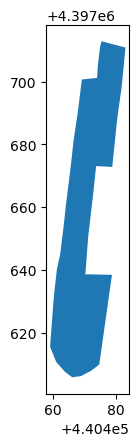

In [54]:
# get single land
single_land = CPP_Planner_Kit.get_single_shp(all_land, 2)
single_land.plot()

In [55]:
def convex_partition(polygon):
    # 将输入多边形转换为Shapely的Polygon对象

    # 初始化凸多边形列表
    convex_polygons = []

    # 创建初始分割线段
    segment = ops.linemerge([polygon.exterior])

    # 迭代进行凸分割
    while segment:
        print(1)
        # 提取分割线段的坐标点
        coords = list(segment.coords)

        # 创建凸多边形
        convex_polygon = Polygon(coords)

        # 将凸多边形添加到列表中
        convex_polygons.append(convex_polygon)

        # 从原多边形中移除已分割的部分
        polygon = polygon.difference(convex_polygon)

        # 创建剩余部分的分割线段
        segment = ops.linemerge([polygon.exterior])

    return convex_polygons
single_polygon = single_land.geometry.iloc[0]
# convex_polygons = convex_partition(single_polygon)

## 将一个多边形，分解为多个凸边形
* 评价：每次尽量分出一个最大的凸边形
* 将当前多边形的非凸边取出
* 遍历每一条非凸边，对集合图形进行分割，得到多个多边形
    * 判断多个多边形：
        * 如果多边形均为凸边形，则结束
        * 如果一个多边形为凸边形，则保存凸边形，而将另外非凸边形放入队列中等待，循环取出

In [56]:
non_convex_polygon = CPP_Planner_Kit.get_non_convex_edges(single_polygon)

Num of convex_hull:  15
Num of Polygon lines:  31
Not on Convex:  20


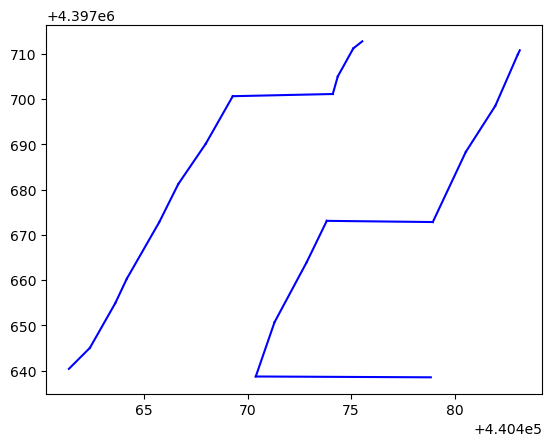

In [57]:
fig, ax = plt.subplots()
for line in non_convex_polygon:
    x, y = line.xy
    ax.plot(x, y, 'b')

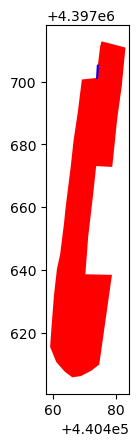

In [58]:
# 模仿一下寻找一条边分割
split_line = non_convex_polygon[8]
# split_line = non_convex_polygon[3]
x, y = split_line.xy
fig, ax = plt.subplots()
single_land.plot(ax=ax, color='r')
ax.plot(x, y, 'b')

Extending lines...
当前分割多边形个数:  1


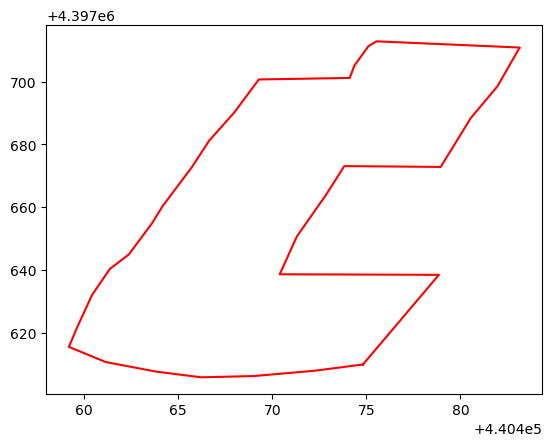

In [59]:
split_polygons = CPP_Planner_Kit.split_polygon_through_1edge(single_polygon, split_line, line_scale_factor=10)
CPP_Planner_Kit.show_geometry_collection(split_polygons)

In [60]:
# 获取 collection 中的每一个几何图形
polygon_list = []
for geom in split_polygons.geoms:
    polygon_list.append(geom)
for polygon in polygon_list:
    print(polygon.area, end=', ')
polygon_list

1249.8772286925375, 

[<POLYGON ((440474.817 4397610.019, 440472.273 4397608.039, 440469.011 439760...>]

In [61]:
polygon_one = polygon_list[0]  # 1 肯定为凹
polygon_convex = polygon_one.convex_hull  # 获取凸包
# 比较凸包和凹边形是否相同，加上 tolerance
# is_same = polygon_convex.equals_exact(polygon_one, tolerance=0.002)
is_same = polygon_one.equals(polygon_convex)
print("equals() same: ", is_same)
# 如果通过面积来判断是否相同呢？例如凸包的面积和凹边形的面积只差不超过10%
if (polygon_convex.area - polygon_one.area) / polygon_one.area < 0.1:
    is_same = True
else:
    is_same = False
print("area() same: ", is_same)

equals() same:  False
area() same:  False


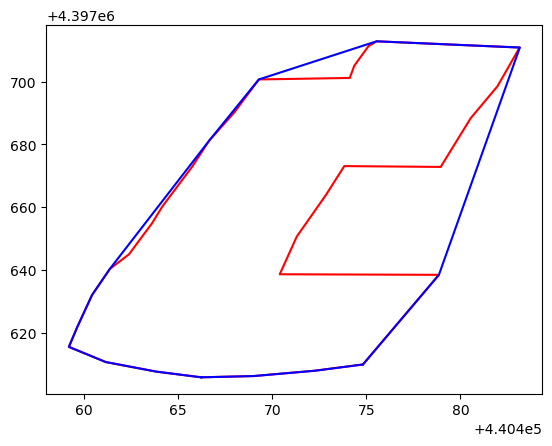

In [62]:
fig, ax = plt.subplots()
x, y = polygon_one.exterior.xy
ax.plot(x, y, 'r')
x, y = polygon_convex.exterior.xy
ax.plot(x, y, 'b')

Num of convex_hull:  15
Num of Polygon lines:  31
Not on Convex:  20


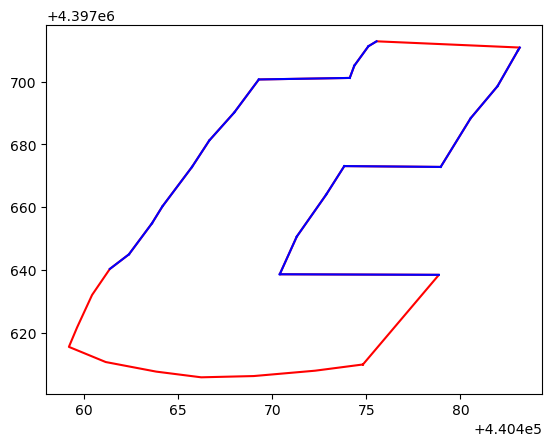

In [63]:
non_conv_edge = CPP_Planner_Kit.get_non_convex_edges(polygon_one)
fig, ax = plt.subplots()
x, y = polygon_one.exterior.xy
ax.plot(x, y, 'r')
for line in non_conv_edge:
    x, y = line.xy
    ax.plot(x, y, 'b')

In [64]:
from CPP_Planner import CPP_Algorithms
# 尝试：用算法试一试分割后的路径规划, split_polygon还原为 geopandas
# gpd_temp_land = gpd.GeoDataFrame(geometry=polygon_list)
paths = []
for polygon in polygon_list:
    temp_gpd = gpd.GeoDataFrame(geometry=[polygon])
    paths.append(CPP_Algorithms.scanline_algorithm_single_no_turn(temp_gpd, 1.4, along_long_edge=True))
# path_temp = CPP_Algorithms.scanline_algorithm_single_no_turn(gpd_temp_land, 1.4, along_long_edge=True)

当前田块角度： 82.62583289801316
根据田块长边开始路径规划...
这次规划完成！


/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:1000: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)


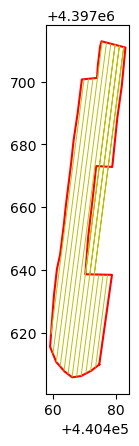

In [65]:
# show land
fig, ax = plt.subplots()
for geom in split_polygons.geoms:
    x, y = geom.exterior.xy
    ax.plot(x, y, 'r')
# path_temp.plot(ax=ax)
for path in paths:
    path.plot(ax=ax, color='y', linewidth=0.7)

# 分解多边形，直到每一个多边形都是非凹

In [66]:
# TODO: 写出田块分解算法，先将整体的算法流程写下来，随后再优化
import queue
def check_split_convex(split_polygon: Polygon, tolerance=0.1):
    print("开始进行田块分割，当前的分割误差允许范围：{}".format(tolerance))
    tolerance = 0.03
    convex = []
    concave = queue.Queue()
    if CPP_Planner_Kit.is_polygon_convex_area_same(split_polygon):
        convex.append(split_polygon)
    else:
        concave.put(split_polygon)
    while not concave.empty():
        temp_concave = concave.get()  # 获取第一个凹边形
        split_group = []  # 专门用来存放每一次按照不同非凸边分割后的结果，方便随后的比较
        # 尝试将凹边形按照不同的边分开，再比较其分的结果
        non_convex_edges = CPP_Planner_Kit.get_non_convex_edges(temp_concave)
        for edge in non_convex_edges:
            split_group.append(CPP_Planner_Kit.split_polygon_through_1edge(temp_concave, edge))
        # print(split_group)
        group_wise_max_area = 0
        group_wise_max_index = -1
        # 找到每一个组内的最大凸边形面积，经过组间比较后，保留最大面积的凸边形所在的组作为分割的办法
        for i in range(len(split_group)):
            group_in_max_area = 0
            group = split_group[i]
            for temp_geom in group.geoms:
                # 如果是凸边形且面积比当前最大面积大
                if CPP_Planner_Kit.is_polygon_convex_area_same(temp_geom, tolerance=tolerance):
                    group_in_max_area = max(group_in_max_area, temp_geom.area)
            # 找到更大面积的多边形，则更新全局最大多边形的面积，以及其分割多边形组的索引
            if group_in_max_area > group_wise_max_area:
                group_wise_max_area = group_in_max_area
                group_wise_max_index = i
        biggest_split = split_group[group_wise_max_index]  # 获取最大的分割
        # CPP_Planner_Kit.show_geometry_collection(biggest_split)
        # 此时需要将已经分割出来的凸边形保存，而非凸边形继续分割
        for temp_polygon in biggest_split.geoms:
            if CPP_Planner_Kit.is_polygon_convex_area_same(temp_polygon, tolerance=tolerance):
                convex.append(temp_polygon)
            else:
                concave.put(temp_polygon)
    print("田块分割结束...")
    return convex
    # now convex contains all convexes split by origin polygon, needs to remake to polygon instead of list
poly = check_split_convex(single_polygon)

开始进行田块分割，当前的分割误差允许范围：0.1
Num of convex_hull:  15
Num of Polygon lines:  31
Not on Convex:  20
Extending lines...
当前分割多边形个数:  1
Extending lines...
当前分割多边形个数:  3
Extending lines...
当前分割多边形个数:  2
Extending lines...
当前分割多边形个数:  3
Extending lines...
当前分割多边形个数:  2
Extending lines...
当前分割多边形个数:  2
Extending lines...
当前分割多边形个数:  3
Extending lines...
当前分割多边形个数:  2
Extending lines...
当前分割多边形个数:  1
Extending lines...
当前分割多边形个数:  1
Extending lines...
当前分割多边形个数:  1
Extending lines...
当前分割多边形个数:  1
Extending lines...
当前分割多边形个数:  3
Extending lines...
当前分割多边形个数:  3
Extending lines...
当前分割多边形个数:  3
Extending lines...
当前分割多边形个数:  2
Extending lines...
当前分割多边形个数:  3
Extending lines...
当前分割多边形个数:  3
Extending lines...
当前分割多边形个数:  3
Extending lines...
当前分割多边形个数:  2
Num of convex_hull:  9
Num of Polygon lines:  22
Not on Convex:  19
Extending lines...
当前分割多边形个数:  1
Extending lines...
当前分割多边形个数:  3
Extending lines...
当前分割多边形个数:  2
Extending lines...
当前分割多边形个数:  3
Extending lines...
当前分割多边形个数:  2
Extending lin

/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


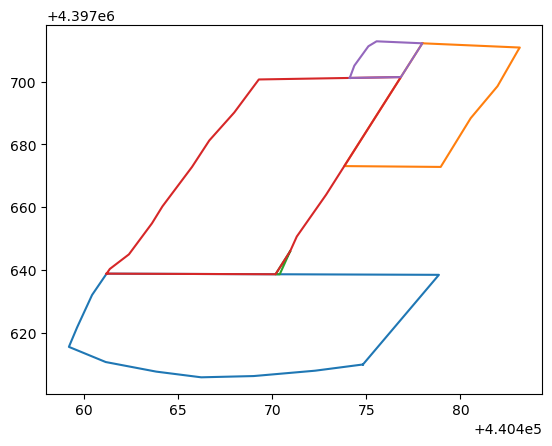

In [67]:
fig, ax = plt.subplots()
for p in poly:
    x, y = p.exterior.xy
    ax.plot(x, y)

当前田块角度： -98.0612397005758
根据田块长边开始路径规划...
这次规划完成！
当前田块角度： 83.935543668999
根据田块长边开始路径规划...
这次规划完成！
当前田块角度： 83.93557469585184
根据田块长边开始路径规划...
这次规划完成！
当前田块角度： 83.49437146441555
根据田块长边开始路径规划...
这次规划完成！
当前田块角度： 83.93553349474897
根据田块长边开始路径规划...
这次规划完成！


/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:1000: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:1000: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:1000: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:1000: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:1000: RuntimeWarning: invalid value enco

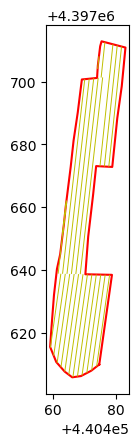

In [68]:
paths = []
for p in poly:
    temp_gpd = gpd.GeoDataFrame(geometry=[p])
    paths.append(CPP_Algorithms.scanline_algorithm_single_no_turn(temp_gpd, 1.4, along_long_edge=True))
# show land
fig, ax = plt.subplots()
for geom in split_polygons.geoms:
    x, y = geom.exterior.xy
    ax.plot(x, y, 'r')
# path_temp.plot(ax=ax)
for path in paths:
    path.plot(ax=ax, color='y', linewidth=0.7)